In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# source files
import sys
sys.path.append('scripts/')
from calibrated_regression import CalibratedRegression
from data_loader import load_quadratic_data

import pymc3 as pm

# plotting
import seaborn as sns
sns.set_style('white')
%matplotlib inline

# Misspecified model

(1250,) (250,) (1250,) (250,)


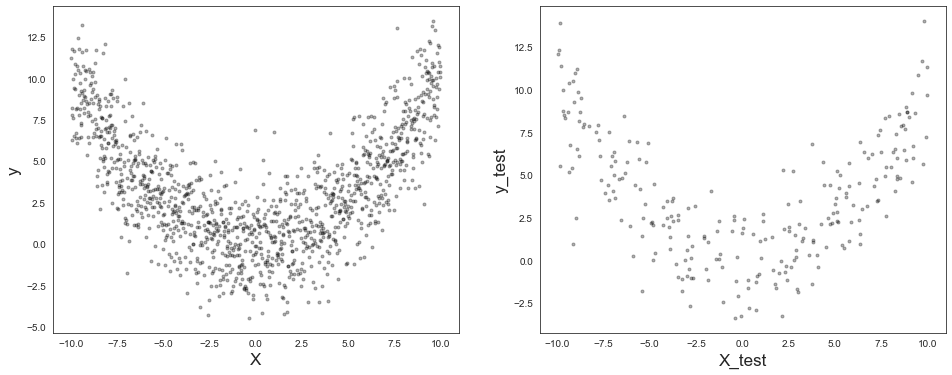

In [2]:
X, X_test, y, y_test = load_quadratic_data()
print(X.shape, X_test.shape, y.shape, y_test.shape)

# plotting X and y and X_test and y_test
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax[0].plot(X, y, 'o', markersize=3, color='black', alpha=0.3)
ax[0].set_xlabel('X', fontsize=17)
ax[0].set_ylabel('y', fontsize=17)

ax[1].plot(X_test, y_test, 'o', markersize=3, color='black', alpha=0.3)
ax[1].set_xlabel('X_test', fontsize=17)
ax[1].set_ylabel('y_test', fontsize=17);

$$
\begin{aligned}
f(x) &= a x^2 + b x + c \\
a &\sim \mathcal{N}(0,1) \\
b &\sim \mathcal{N}(0,1) \\
c &\sim \mathcal{N}(0,1) \\
\end{aligned}
$$

Finally, we get: 

$$
y \sim \mathcal{N}(\mu,\sigma), \quad \mu = f(x), \sigma=1
$$

In [3]:
with pm.Model() as model:
    a = pm.Normal('a', mu=0, sigma=1)
    b = pm.Normal('b', mu=0, sigma=1)
    c = pm.Normal('c', mu=0, sigma=1)
    
    f_x = a*X**2 + b*X + c
    y_obs = pm.Normal('y', mu=f_x, sigma=1, observed=y)
    
    trace = pm.sample(1000, tune=1000)
    
pm.summary(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, b, a]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1514.97draws/s]
/Users/anthonyrentsch/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,0.099974,0.000933,0.000019,0.098133,0.101703,2327.848031,1.000136
b,0.019475,0.004908,0.000090,0.010107,0.029058,2896.617136,1.000422
c,0.030256,0.041034,0.000773,-0.051322,0.110279,2557.343692,1.000260


In [4]:
def posterior_predictive(x, a, b, c, sigma=1):
    '''Returns samples from posterior predictive.
    
    Parameters
    ----------
    x : array-like
        Data
    a : np.array
        Posterior samples of a
    b : np.array
        Posterior samples of b
    c : np.array
        Posterior samples of c
    sigma : float
        Standard deviation of observation noise
            
    Returns
    -------
    samples : np.array
    '''
    x, a, b, c = x.reshape(-1,1), a.reshape(-1,1), b.reshape(-1,1), c.reshape(-1,1)
    noise = np.random.normal(scale=sigma, size=a.shape[0])
    samples = (x**2).dot(a.T) + x.dot(b.T) + np.ones(x.shape).dot(c.T) + noise
    return samples

In [5]:
a, b, c = trace['a'][:-1000], trace['b'][:-1000], trace['c'][:-1000]

# fitting the calibrated regressor
pp_params = {'a': a, 'b': b, 'c': c}
calib = CalibratedRegression(X, y, model, pp=posterior_predictive, pp_params=pp_params).fit()

# creating the results dataframe
df_results, pred_cdf, emp_cdf = calib.create_calibration_dataset()
display(df_results.head())

# getting quantiles
quants = [0.05, 0.5, 0.95]
print(calib.predict_quantiles(quants))

,X,y,predicted_cdf,empirical_cdf
0,7.945297,7.240519,0.762667,0.644
1,2.421614,4.572232,1.000000,1.000
2,-6.731154,3.301530,0.121333,0.292
3,3.769179,2.330752,0.779667,0.660
4,-6.531021,3.446798,0.226000,0.392


[9.58333333e-04 4.63000000e-01 9.99166667e-01]


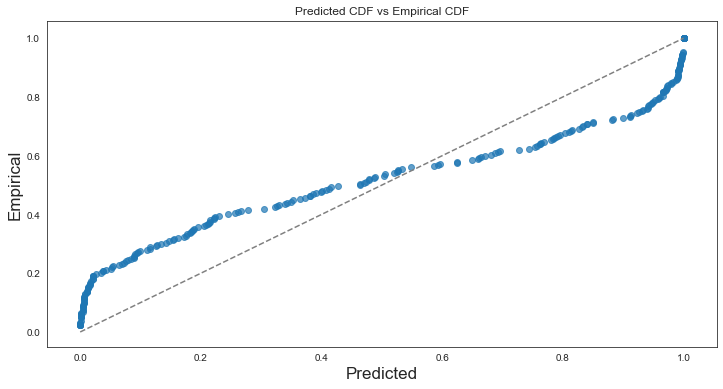

In [6]:
# plotting calibration curve
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
calib.plot_calibration_curve(ax);

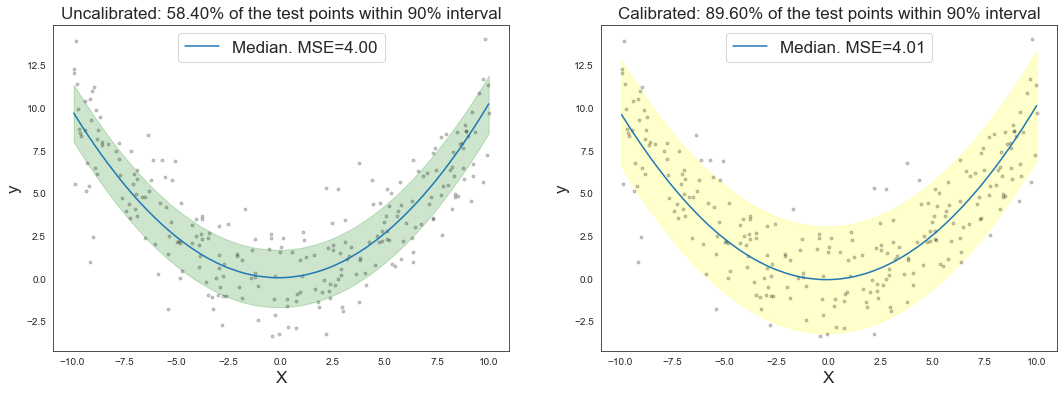

In [7]:
# checking new posterior predictive intervals
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
_, cal_quants, unc_quants = calib.plot_intervals(ax, X_test, y_test, quantiles=[0.05, 0.5, 0.95]);

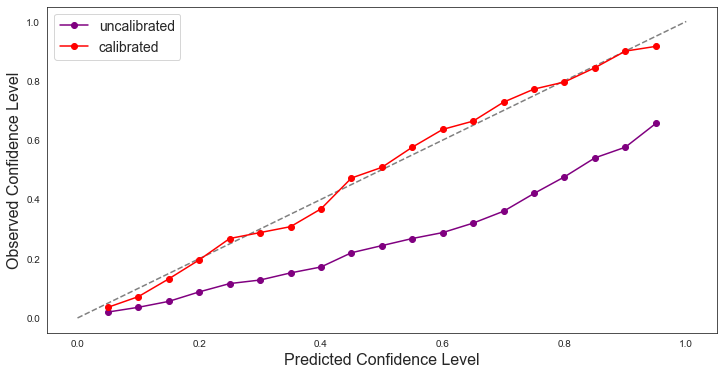

In [8]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
calib.plot_diagnostic_curve(ax, X_test, y_test);

# Epistemic uncertainty

In [9]:
f = lambda x: np.sin(0.05*x**2) + 4 + np.random.normal(0, 0.4, size=len(x))
X = np.concatenate([np.linspace(-10, -7, 40),
                         np.linspace(-7, 5, 10),
                         np.linspace(5, 10, 40)])
y = f(X)

X_test = np.linspace(X.min(), X.max(), 200)
y_test = f(X_test)

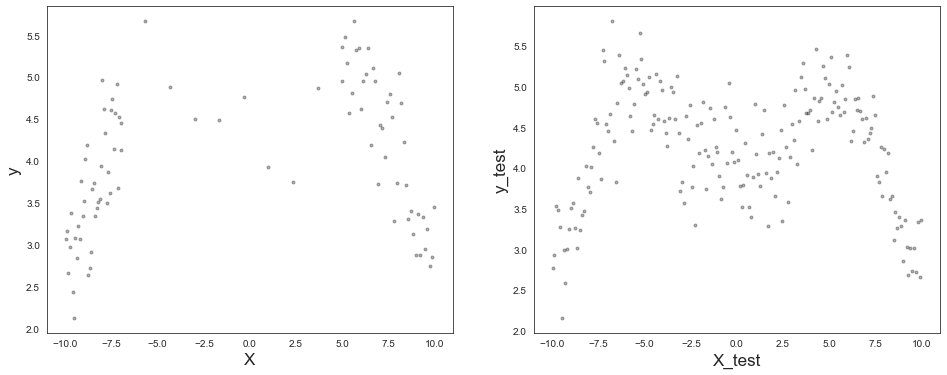

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

ax[0].plot(X, y, 'o', markersize=3, color='black', alpha=0.3)
ax[0].set_xlabel('X', fontsize=17)
ax[0].set_ylabel('y', fontsize=17)

ax[1].plot(X_test, y_test, 'o', markersize=3, color='black', alpha=0.3)
ax[1].set_xlabel('X_test', fontsize=17)
ax[1].set_ylabel('y_test', fontsize=17);

$$
\begin{aligned}
f(x) &= e \sin(d \cos x + a x^2) + b x + c \\
a &\sim \mathcal{N}(0,1) \\
b &\sim \mathcal{N}(0,1) \\
c &\sim \mathcal{N}(0,1) \\
d &\sim \mathcal{N}(0,1) \\
e &\sim \mathcal{N}(0,1) \\
\end{aligned}
$$

Finally, we get: 

$$
y \sim \mathcal{N}(\mu,\sigma), \quad \mu = f(x), \sigma=0.4
$$

In [11]:
with pm.Model() as model:
    a = pm.Normal('a', mu=0, sigma=1) 
    b = pm.Normal('b', mu=0, sigma=1) 
    c = pm.Normal('c', mu=0, sigma=1) 
    d = pm.Normal('d', mu=0, sigma=1) 
    e = pm.Normal('e', mu=0, sigma=1) 
    
    f_x = e*pm.math.sin(d*pm.math.cos(X) + a*X**2) + b*X + c
    y_obs = pm.Normal('y', mu=f_x, sigma=0.4, observed=y)
    
    trace = pm.sample(1000, tune=1000)
    
pm.summary(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [e, d, c, b, a]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1615.19draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/Users/anthonyrentsch/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,0.055238,0.473524,0.047351,-0.354494,0.815954,2.001101,144.857020
b,0.024822,0.009936,0.000836,0.003581,0.039529,2.675224,2.037374
c,4.041385,0.085763,0.007320,3.919173,4.229953,2.615155,2.111892
d,0.726796,0.530035,0.043559,-0.183385,1.574283,2.818821,1.912169
e,-0.084834,0.575278,0.057140,-1.171403,0.362597,2.023013,9.815533


In [12]:
def posterior_predictive(x, e, d, a, b, c, sigma=1):
    x, e, d, a, b, c = x.reshape(-1,1), e.reshape(-1,1), d.reshape(-1,1), a.reshape(-1,1), b.reshape(-1,1), c.reshape(-1,1)
    noise = np.random.normal(scale=sigma, size=a.shape[0])
    samples = np.sin(np.cos(x).dot(d.T) + (x**2).dot(a.T))*(e.T) + x.dot(b.T) + np.ones(x.shape).dot(c.T) + noise
    return samples

In [13]:
e, d, a, b, c = trace['e'][:-1000], trace['d'][:-1000], trace['a'][:-1000], trace['b'][:-1000], trace['c'][:-1000]

# fitting the calibrated regressor
pp_params = {'e':e, 'd':d, 'a': a, 'b': b, 'c': c}
calib = CalibratedRegression(X, y, model, pp=posterior_predictive, pp_params=pp_params).fit()

# creating the results dataframe
df_results, pred_cdf, emp_cdf = calib.create_calibration_dataset()
display(df_results.head())

# getting quantiles
quants = [0.05, 0.5, 0.95]
print(calib.predict_quantiles(quants))

,X,y,predicted_cdf,empirical_cdf
0,-8.076923,3.938506,0.522667,0.611111
1,7.820513,3.282715,0.220333,0.166667
2,9.871795,2.854100,0.087000,0.055556
3,-8.461538,3.735231,0.466667,0.500000
4,7.948718,3.731891,0.284667,0.277778


[0.08266667 0.47166667 0.86626667]


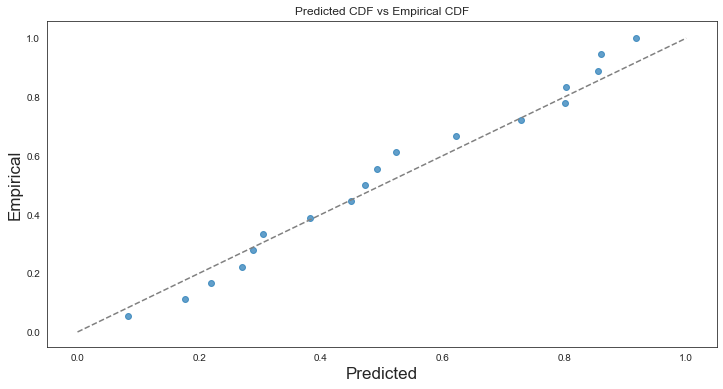

In [14]:
# plotting calibration curve
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
calib.plot_calibration_curve(ax);

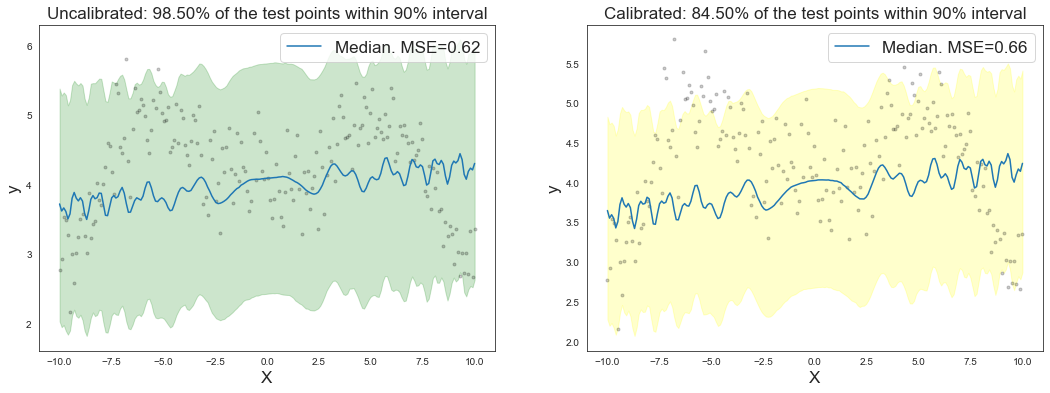

In [15]:
# checking new posterior predictive intervals
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
_, cal_quants, unc_quants = calib.plot_intervals(ax, X_test, y_test, quantiles=[0.05, 0.5, 0.95]);

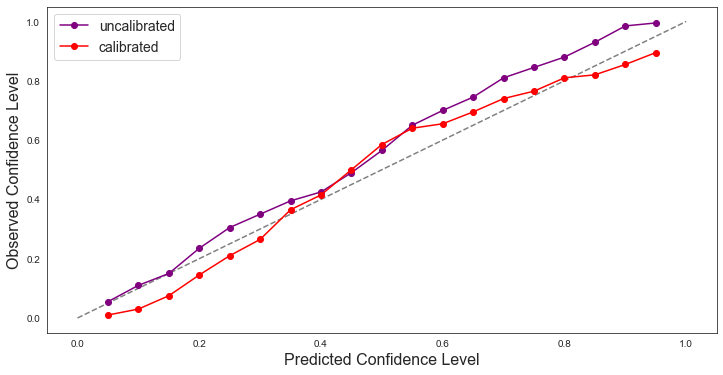

In [16]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
calib.plot_diagnostic_curve(ax, X_test, y_test);